In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All the libraries are downloaded here
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#creating dataset
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400

# this function  take the image before creating the dataset and resizes it ans normalizes the image
def load_data(image_path):
    image = tf.io.read_file(image_path)# Reads the file
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])# Resize the image in 256X256 image
    image = image / 255.0  #normalize the array
    return image

# This function collects the data and make the dataset from the images given by load_data function
def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE) # Making of the dataset
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/drive/MyDrive/dataset/datset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/dataset/datset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("/content/drive/MyDrive/dataset/datset/eval15/low/*"))

train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [ ]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [ ]:
#color consistency loss
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [ ]:
#exposure loss
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


In [ ]:
#smoothness loss
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [ ]:
#spatial consistency loss

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


Epoch 1/20
25/25 [==============================] - 11s 316ms/step - total_loss: 3.6699 - illumination_smoothness_loss: 0.7962 - spatial_constancy_loss: 1.9930e-04 - color_constancy_loss: 0.0032 - exposure_loss: 2.8703 - val_total_loss: 3.0187 - val_illumination_smoothness_loss: 0.1068 - val_spatial_constancy_loss: 3.4629e-04 - val_color_constancy_loss: 5.0864e-04 - val_exposure_loss: 2.9110
Epoch 2/20
25/25 [==============================] - 7s 294ms/step - total_loss: 2.7983 - illumination_smoothness_loss: 0.0527 - spatial_constancy_loss: 0.0011 - color_constancy_loss: 0.0041 - exposure_loss: 2.7404 - val_total_loss: 2.8055 - val_illumination_smoothness_loss: 0.0364 - val_spatial_constancy_loss: 0.0018 - val_color_constancy_loss: 8.4172e-04 - val_exposure_loss: 2.7664
Epoch 3/20
25/25 [==============================] - 7s 269ms/step - total_loss: 2.6188 - illumination_smoothness_loss: 0.0449 - spatial_constancy_loss: 0.0038 - color_constancy_loss: 0.0060 - exposure_loss: 2.5641 - val

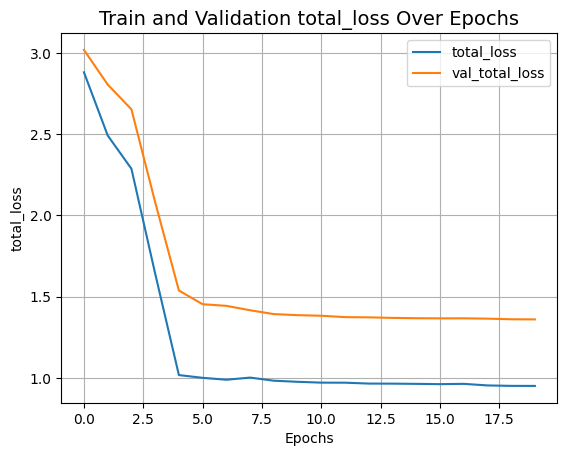

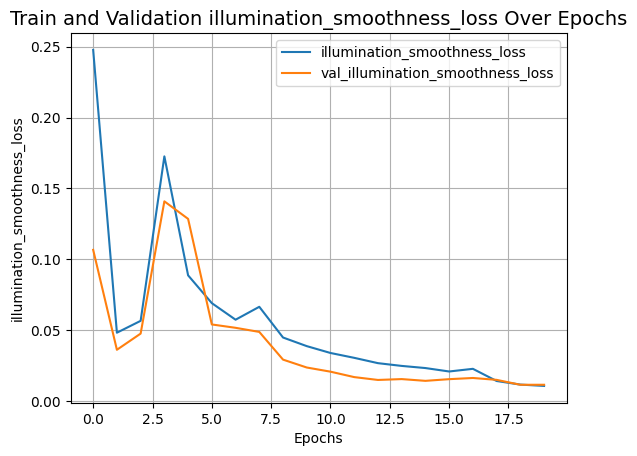

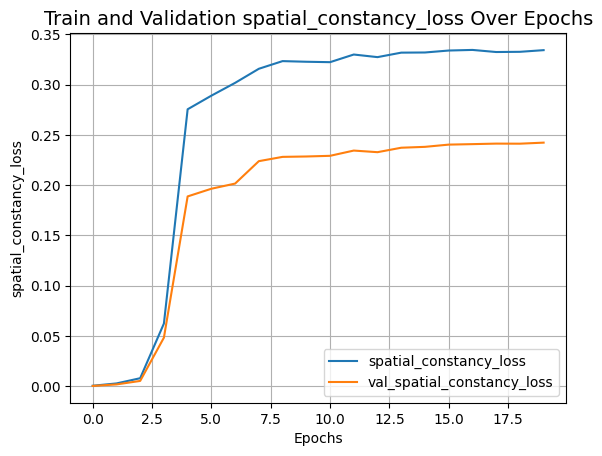

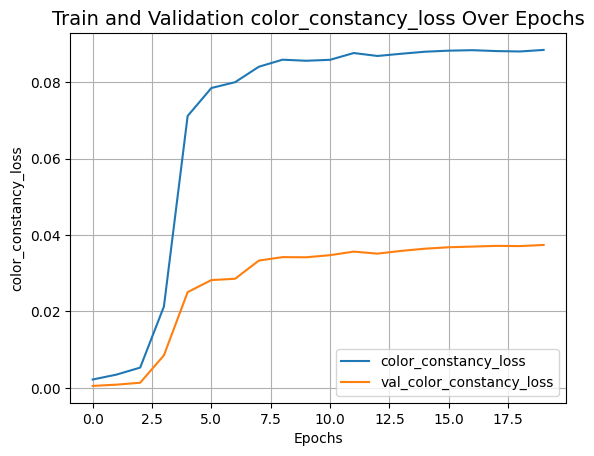

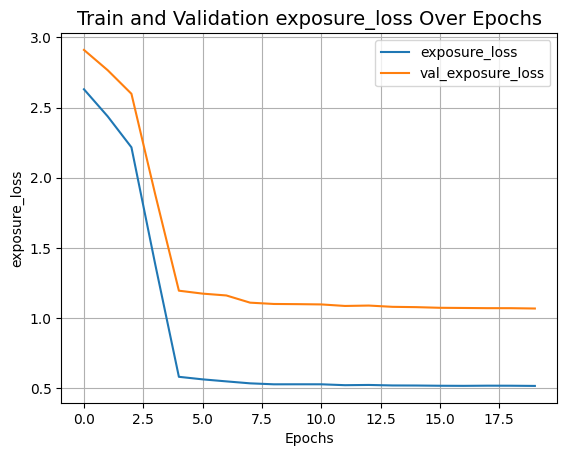

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-3)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=20)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [ ]:
#results
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


In [ ]:
output=[]
for val_image_file in test_low_light_images:
  original_image=Image.open(val_image_file)
  output_image=infer(original_image)
  output.append(output_image)

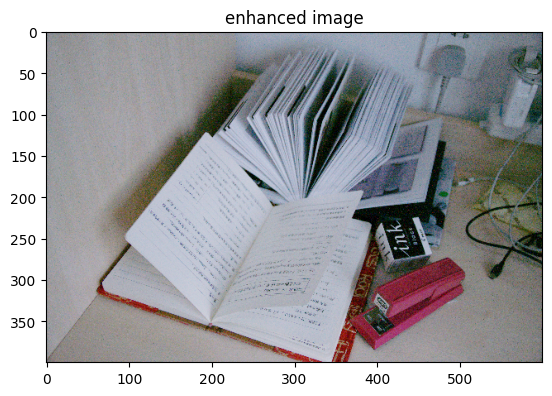

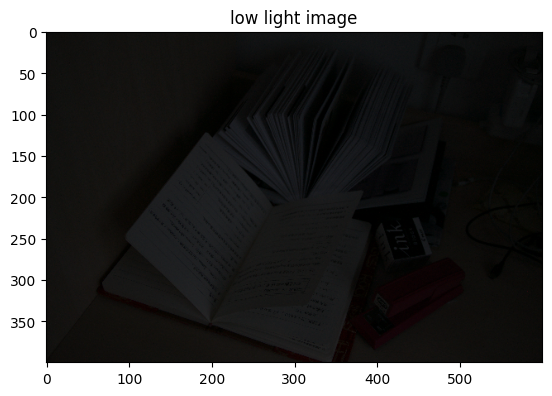

In [ ]:
plt.imshow(output[7])
plt.title('enhanced image')
plt.show()
img=Image.open(test_low_light_images[7])
plt.title('low light image')
plt.imshow(img)
plt.show()

In [ ]:
zero_dce_model.save_weights('/content/drive/MyDrive/dce_model2.h5')

In [ ]:
zero_dce_model1=ZeroDCE()
zero_dce_model1.load_weights('/content/drive/MyDrive/dce_model2.h5')

In [ ]:
image_path1='/content/drive/MyDrive/dataset/datset/eval15/low/1.png'
image_path2='/content/drive/MyDrive/dataset/datset/eval15/high/1.png'

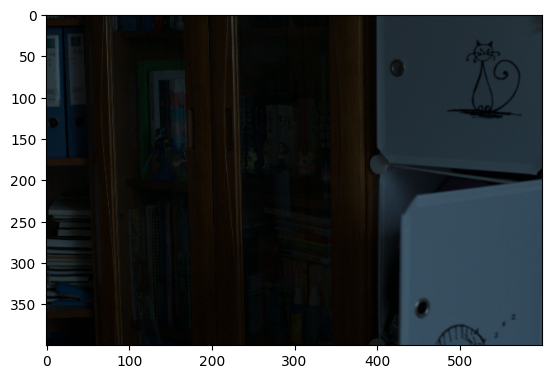

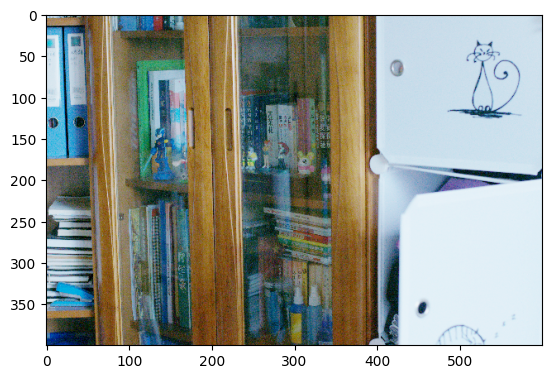

In [ ]:

image=Image.open(image_path1)
plt.imshow(image)
plt.show()
image2=Image.open(image_path2)
image_array=np.array(image)
image_tensor=tf.convert_to_tensor(image_array,dtype=tf.float32)/255.0
image_tensor=tf.expand_dims(image_tensor,axis=0)
output_tensor=zero_dce_model1(image_tensor)
output_image_array=tf.cast(output_tensor[0,:,:,:]*255,dtype=tf.uint8).numpy()
output_image=Image.fromarray(output_image_array)
plt.imshow(output_image)
plt.show()

In [ ]:
def calculate_psnr(original_image, enhanced_image):
    # Ensure the input images are in the correct format and dimensions
    original_image = np.array(original_image, dtype=np.float32)
    enhanced_image = np.array(enhanced_image, dtype=np.float32)

    if original_image.shape != enhanced_image.shape:
        raise ValueError("Input images must have the same dimensions and channels")

    # Compute the Mean Squared Error (MSE)
    mse = np.mean((original_image - enhanced_image) ** 2)

    if mse == 0:
        return float('inf')  # If the MSE is zero, the PSNR is infinite

    # Set the maximum pixel value
    max_pixel_value = 255.0

    # Compute the PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr

In [ ]:
calculate_psnr(image2,output_image)

19.1135450306039

In [ ]:
high=[]
low=[]
result=[]
path1='/content/drive/MyDrive/dataset/datset/eval15/high'
path2='/content/drive/MyDrive/dataset/datset/eval15/low'

def form_dataset(location,name):
  files=sorted(os.listdir(path1))
  for filename in files:
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image formats
        file_path = os.path.join(location, filename)

        # Open the image file
        with Image.open(file_path) as img:
            # Convert image to RGB (optional, depending on your needs)
            img = img.convert('RGB')

            # Append the image to the array
            name.append(img)



# for file in low:
#   output=enhance(file)
#   enhance.append(output)
def make_data(image):
  result.append(image)

def l(image):
   image_array=np.array(image)
   image_tensor=tf.convert_to_tensor(image_array,dtype=tf.float32)/255.0
   image_tensor=tf.expand_dims(image_tensor,axis=0)
   output_tensor=zero_dce_model1(image_tensor)
   output_image_array=tf.cast(output_tensor[0,:,:,:]*255,dtype=tf.uint8).numpy()
   output_image=Image.fromarray(output_image_array)
   return output_image

form_dataset(path1,high)
form_dataset(path2,low)

for i in range(0, len(low)):
    result.append(l(low[i]))
print(low)
print(high)
print(result)
# for i in range(0,5):
#   plt.imshow(low[i])
#   plt.show()

[<PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C03D0>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C1F00>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C25F0>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C1120>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C2920>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C3C70>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C2C50>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C159DE0>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C1540>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C0100>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C0C70>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C0D00>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C3A60>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C09A0>, <PIL.Image.Image image mode=RGB size=600x400 at 0x7D477C1C2320>]
[<PIL.Image.Image image 

In [ ]:
def display_images_in_row(images):
    # Load images from paths
    # images = [Image.open(image_path) for image_path in image_paths]

    # Determine the number of images
    num_images = 4
    # Create a figure with a single row of subplots
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable when only one image

    # Display each image in the corresponding subplot
    for ax, image in zip(axes, images):
        ax.imshow(image)
        ax.axis('off')  # Hide axes for better visualization

    plt.tight_layout()
    plt.show()


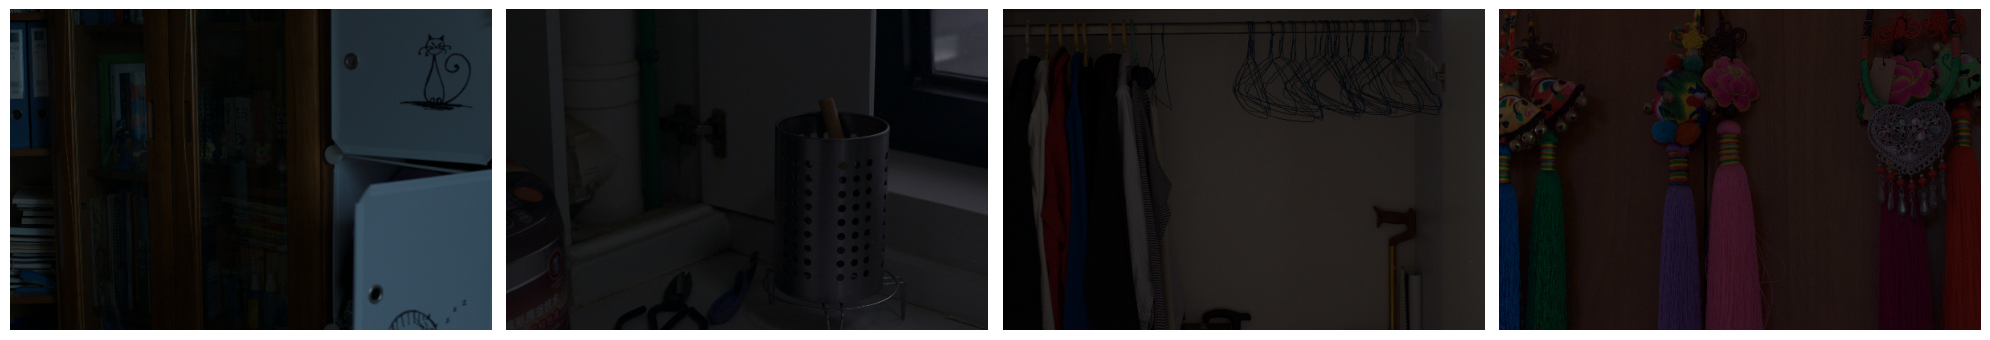

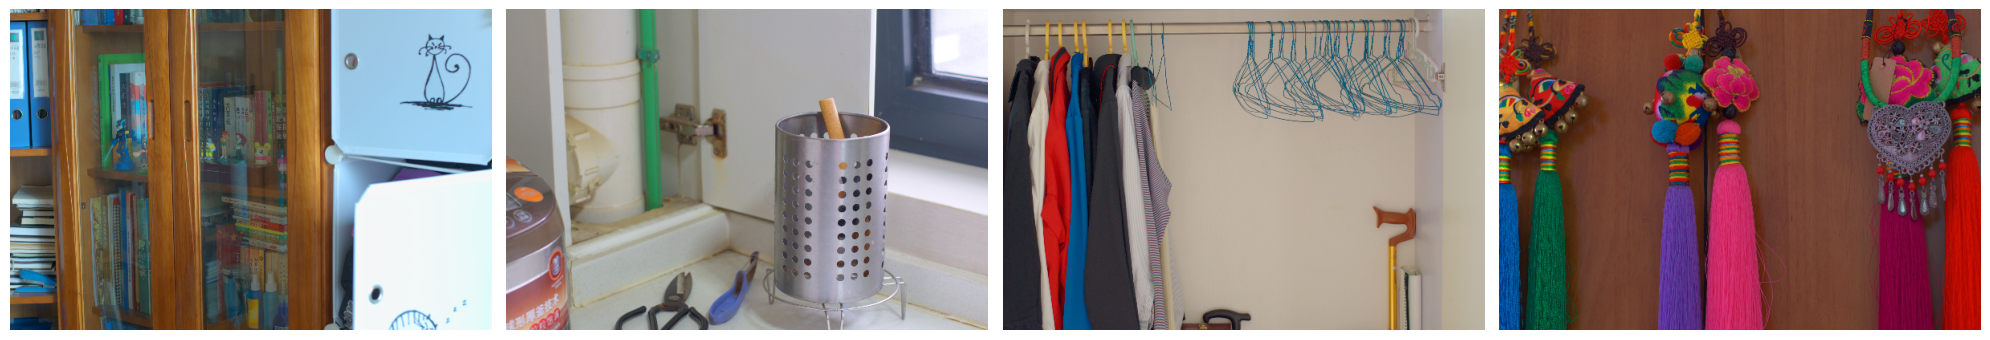

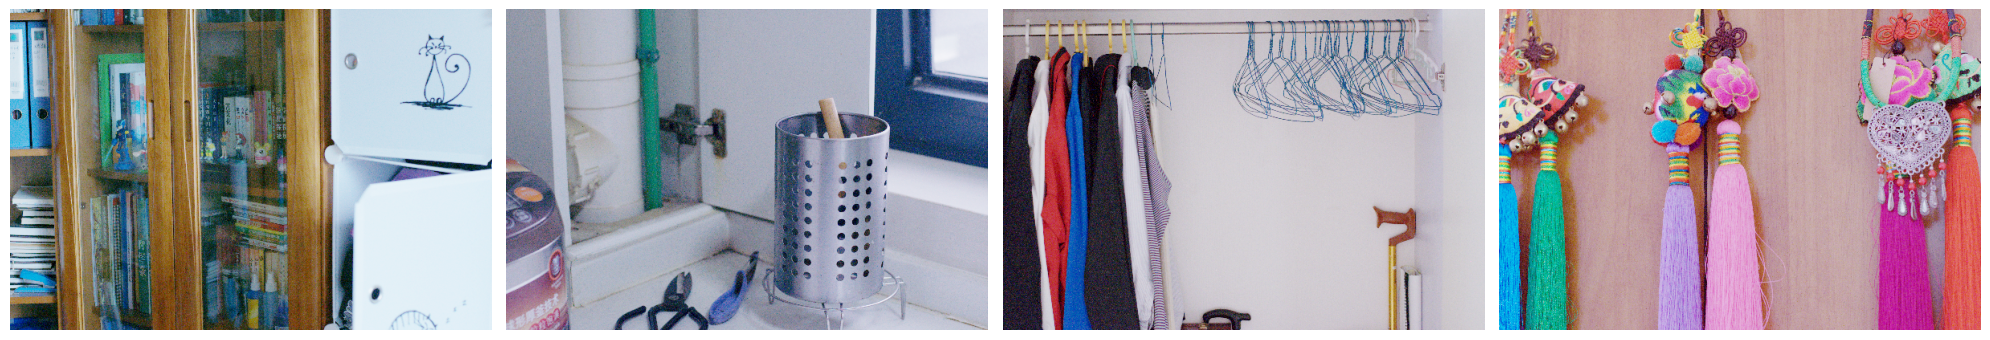

In [ ]:
display_images_in_row(low)
display_images_in_row(high)
display_images_in_row(result)

In [ ]:
calculate_psnr(high[14],result[14])

24.319463214886014